In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (11, 7)

/Users/serg_mo/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/serg_mo/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
financial_features =  ['salary', 'deferral_payments', 'total_payments', 
                       'loan_advances', 'bonus', 'restricted_stock_deferred', 
                       'deferred_income', 'total_stock_value', 'expenses', 
                       'exercised_stock_options', 'other', 'long_term_incentive', 
                       'restricted_stock', 'director_fees']

email_features =  ['to_messages', 'email_address', 'from_poi_to_this_person', 
                   'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

label = ['poi']

data = pd.read_csv('enron_employees.csv', na_values='NaN')

In [3]:
fin_data = data[['full_name'] + financial_features + label]

In [4]:
print("Number of POIs:\t\t" + str(len(data[data.poi == True])))
print("Number of non-POIs:\t" + str(len(data[data.poi == False])))
print("Total number:\t\t" + str(len(data)))

Number of POIs:		18
Number of non-POIs:	127
Total number:		145


In [5]:
fin_data.poi.describe()

count       145
unique        2
top       False
freq        127
Name: poi, dtype: object

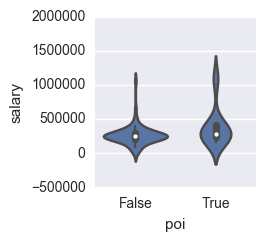

In [8]:
g = sns.PairGrid(fin_data, x_vars=['poi'], y_vars=['salary'])
g.map(sns.violinplot)